<a href="https://colab.research.google.com/github/AndyLam1224/Fake-News-Detector/blob/master/Fake_News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt  
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.utils import shuffle
import csv
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk 
vocab_size = 30000
embed_dim = 128
max_length = 28
lstm_out = 196


In [0]:
# onion = pd.read_csv("/content/TheOnion_tweets.csv")  
# # onion = onion.head(1750)

# fakecnn = pd.read_csv("/content/TheFakeCNN_tweets.csv")
# # fakecnn = fakecnn.head(1750)

fake = pd.read_csv("/content/fake.csv", usecols=['title'])
fake = fake.dropna()
fake = fake.rename(columns={'title':'text'})
fake['is_fake'] = 1

# fake = pd.concat([onion,fakecnn], axis=0)
# fake['is_fake'] = 1

npr = pd.read_csv("/content/npr_tweets.csv")
# npr = npr.head(2000)

nytimes = pd.read_csv("/content/nytimes_tweets.csv")
# nytimes = nytimes.head(2000)

econ = pd.read_csv("/content/EconUS_tweets.csv")
# econ = econ.head(2000)

breakingnews = pd.read_csv("/content/breakingnews_tweets.csv")
# breakingnews = breakingnews.head(1000)

real = pd.concat([npr,nytimes, econ, breakingnews], axis=0)
real['is_fake'] = 0


In [125]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12319 entries, 0 to 12912
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     12319 non-null  object
 1   is_fake  12319 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 288.7+ KB


In [0]:
# fakeyahoo = pd.read_csv("/content/fakeyahoonews_tweets.csv")
# fakeyahoo['is_fake'] = 1

# cnn = pd.read_csv("/content/cnn_tweets.csv")
# cnn = cnn.head(200)
# cnn['is_fake'] = 0

# new_test = pd.concat([fakeyahoo,cnn],axis=0)
# new_test.shape

In [0]:

def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    if text[0] == 'b':
      text = text[1:]
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text= text.replace('xexx','')
    return text


real = real[~real['text'].astype(str).str.startswith('RT')]
real['text'] = real['text'].astype(str).apply(lambda x:initial_clean(x))
# Drop all retweets 
real = real[~real['text'].astype(str).str.startswith('rt')]

fake = fake[~fake['text'].astype(str).str.startswith('RT')]
fake['text'] = fake['text'].astype(str).apply(lambda x:initial_clean(x))
# Drop all retweets 
fake = fake[~fake['text'].astype(str).str.startswith('rt')]


# new_test = new_test[~new_test['text'].astype(str).str.startswith('RT')]
# new_test['text'] = new_test['text'].astype(str).apply(lambda x:initial_clean(x))
# new_test = shuffle(new_test)

In [0]:
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
# def 
# text_tokens = word_tokenize(text)

# tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]


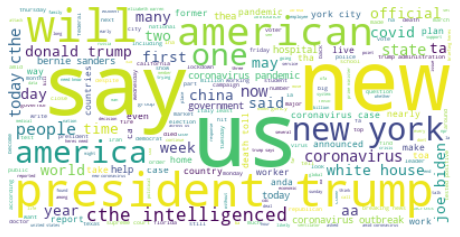

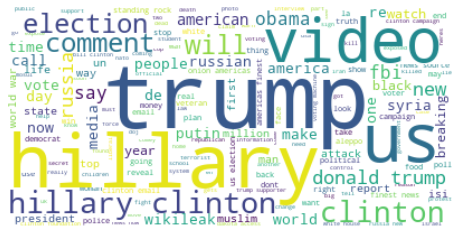

In [128]:
def generate_cloud(df):
    stopwords = set(STOPWORDS)
    words = " ".join(text for text in df.text)

    wordcloud = WordCloud(background_color = 'white', stopwords=stopwords, max_font_size=80, max_words=300).generate(words)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
generate_cloud(real)
generate_cloud(fake)

In [129]:
data = pd.concat([real,fake], axis=0)
data = shuffle(data)
data.head()
data.shape

# train = data.head(2000)
# test = data.tail(771)

# test.head()

(23879, 4)

In [130]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# stemmer = PorterStemmer()
# def stem_text(text):
#     final_text = []
#     for i in text.split():
#         if i.strip().lower() not in stop:
#             word = stemmer.stem(i.strip())
#             final_text.append(word)
#     return " ".join(final_text)    
# data.text = data.text.apply(stem_text)    

In [132]:
data.head()

,id,created_at,text,is_fake
2767,1.033783e+18,2018-08-26 18:27:33,sheriffs office at jacksonville mass shootin...,0
10363,NaN,NaN,syrian war report november militants were ...,1
1309,NaN,NaN,donald j trumps point plan to put america fir...,1
963,1.229152e+18,2020-02-16 21:13:55,in the s of american households moved each ye...,0
1731,1.151879e+18,2019-07-18 15:37:40,judge denies bail for jeffrey epstein cites ri...,0


In [0]:
# X_train = train['text']
# y_train = train['is_fake']

# X_test = new_test['text']
# y_test = new_test['is_fake']

In [0]:
X = data['text']
y = data['is_fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
  tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")
  tokenizer.fit_on_texts(X_train)
  word_index = tokenizer.word_index

  training_sequences = tokenizer.texts_to_sequences(X_train)
  training_padded = pad_sequences(training_sequences,maxlen = 28, padding = 'post', truncating='post')
  X_train = np.array(training_padded)

  testing_sequences = tokenizer.texts_to_sequences(X_test)
  testing_padded = pad_sequences(testing_sequences, maxlen=28, padding = 'post', truncating='post')
  X_test = np.array(testing_padded)

In [0]:
# model = Sequential()
# model.add(Dense(units = 100 , activation = 'relu' , input_dim = X_train.shape[1]))
# model.add(Dense(units = 50 , activation = 'relu'))
# model.add(Dense(units = 25 , activation = 'relu'))
# model.add(Dense(units = 10 , activation = 'relu'))
# model.add(Dense(units = 1 , activation = 'sigmoid'))
# model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# model.fit(X_train,y_train , epochs = 10, batch_size=32)

# New Section

In [144]:
model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = X_train.shape[1],mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, activation = 'relu', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

batch_size = 32
model.fit(X_train, y_train, epochs=3, batch_size=batch_size, validation_data = (X_test, y_test))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 28, 128)           3840000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 197       
Total params: 4,094,997
Trainable params: 4,094,997
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19103 samples, validate on 4776 samples
Epoch 1/3
19103/19103 [==============================] - 89s 5ms/step - loss: 0.3179 - accuracy: 0.8833 - val_loss: 0.1488 - val_accuracy: 0.9407
Epoch 2/3
19103/19103 [==============================] - 89s 5ms/step - loss: 0.0803 - accuracy: 0.9696 - val_loss: 0.1388 - val_accuracy: 0.9470
Epoch 3/3
19103/19103 [==============================] - 88s 5ms/step - loss: 0.0306 - accuracy: 0.9881 - val_loss: 0.1617 - val_accuracy: 0.9510


In [138]:
batch_size=32
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score)) 
print("acc: %.2f" % (acc)) 

score: 0.50
acc: 0.91


In [139]:
pred = model.predict(X_test,verbose = 2)
for i in range(len(pred)):
  if pred[i] <= 0.5:
    pred[i] = 0
  else:
    pred[i] = 1
y_test = np.array(y_test).reshape(-1,1)
num_cor = 0

for j in range(len(y_test)):
  if pred[i] == y_test[i]:
    num_cor += 1

print("Total number correct: ", num_cor, "out of: ", y_test.size)

Total number correct:  4776 out of:  4776


In [140]:
print(score, acc)

0.5015285996036913 0.9149916172027588


In [143]:
twt =["the reaction of urban house-sharers will play a vital role in how America copes with the disease"]

#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, padding = 'post', truncating='post')
is_fake = model.predict(twt,batch_size=1,verbose = 2)
print(is_fake)
if(is_fake < 0.5):
    print("Real")
else:
    print("Fake")

[[0.44089893]]
Real
